Problem 3

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t,norm
from riskmgmt import *

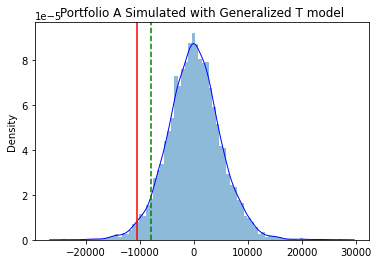

For Portfolio A,
Current price is 299950.05907389
VaR is 7924.45440194544
ES is 10469.504082020962


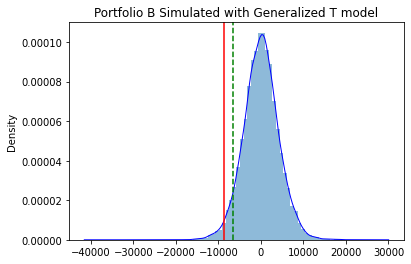

For Portfolio B,
Current price is 294385.59081765
VaR is 6693.189181940956
ES is 8795.589522813323


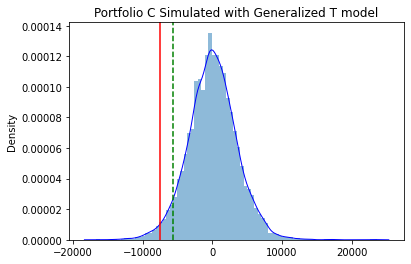

For Portfolio C,
Current price is 270042.8305277
VaR is 5653.332579016406
ES is 7439.533622014646


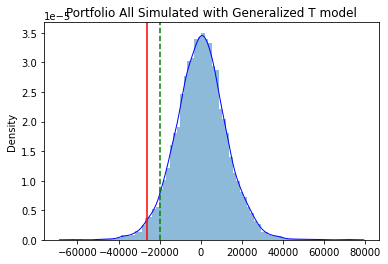

For Portfolio All,
Current price is 864378.48041924
VaR is 19820.953528746715
ES is 26274.35367291905


In [26]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")
portfolio_code = ['A','B','C','All']

for code in portfolio_code:
    current_price, assets_prices, holdings = get_portfolio_price(portfolio,prices,code)
    assets_returns = return_calculate(assets_prices)
    assets_returns.drop('Date', axis=1, inplace=True)
    norm_assets_returns = assets_returns - assets_returns.mean()
    parameters = []
    assets_returns_cdf = pd.DataFrame()
    for stock in norm_assets_returns.columns.tolist():
        params = Fitting_t_MLE(norm_assets_returns[stock])
        parameters.append(params)
        assets_returns_cdf[stock] = t.cdf(norm_assets_returns[stock],df=params[0], loc=params[1], scale = params[2])

    np.random.seed(1)
    spearman_corr_matrix = assets_returns_cdf.corr(method='spearman')
    sim_sample = multivariate_normal_simulation(spearman_corr_matrix, 10000, method='pca')
    sim_sample = pd.DataFrame(sim_sample, columns=assets_returns.columns)

    sim_sample_cdf = pd.DataFrame()
    for stock in sim_sample.columns.tolist():
        sim_sample_cdf[stock] = norm.cdf(sim_sample[stock],loc=0,scale=1)

    sim_returns = pd.DataFrame()
    for i, stock in enumerate(sim_sample.columns.tolist()):
        sim_returns[stock] = t.ppf(sim_sample_cdf[stock], df=parameters[i][0], loc=parameters[i][1], scale = parameters[i][2])

    assets_prices.drop('Date', axis=1, inplace=True)
    sim_prices = np.dot(sim_returns* assets_prices.tail(1).values.reshape(assets_prices.shape[1],),holdings)

    VaR_T = var(sim_prices)
    ES_T = es(sim_prices, VaR_T)

    plt.hist(sim_prices, bins=80, density=True, alpha=0.5)
    sns.kdeplot(sim_prices, color='blue', linewidth=1)
    plt.axvline(-VaR_T, color='green', linestyle='--')
    plt.axvline(-ES_T, color='red', linestyle='-')
    plt.title('Portfolio {} Simulated with Generalized T model'.format(code))
    plt.show()
    
    print("For Portfolio {}," .format(code))
    print("Current price is {}".format(current_price[0]))
    print("VaR is {}" .format(VaR_T))
    print("ES is {}" .format(ES_T))